<a href="https://colab.research.google.com/github/IsaacBrrP/ARLETEX/blob/main/EDA_Arletex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ── CELDA 0: Setup & Carga ──────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"figure.dpi": 130, "font.size": 10})

# ── Carga (sube el CSV a Colab o monta Drive) ────────────────────────────────
# Opción A – subir manualmente
from google.colab import files
uploaded = files.upload()
fname = list(uploaded.keys())[0]

# Opción B – si ya está en Drive, comenta A y usa:
# fname = "/content/drive/MyDrive/CopiaProductos Vendidos_Limpia.csv"

df = pd.read_csv(fname, encoding="latin1", low_memory=False)

# ── Limpieza básica de nombres ────────────────────────────────────────────────
df.columns = df.columns.str.strip()

# ── Parseo de fechas ─────────────────────────────────────────────────────────
df["Fecha_Ini"] = pd.to_datetime(df["Fecha_Ini"], errors="coerce")
df["Fecha_Fin"] = pd.to_datetime(df["Fecha_Fin"], errors="coerce")

# ── Limpieza de columnas numéricas con comas ─────────────────────────────────
num_cols = ["Cant", "PU", "Costo_Unitario", "Utilidad", "Subtotal",
            "IVA", "Total", "Utilidad%"]
for c in num_cols:
    if c in df.columns:
        df[c] = (df[c].astype(str)
                       .str.replace(",", "", regex=False)
                       .str.strip())
        df[c] = pd.to_numeric(df[c], errors="coerce")

print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(df.dtypes.to_string())

Saving CopiaProductos Vendidos_Limpia.csv to CopiaProductos Vendidos_Limpia (1).csv
✅ Dataset cargado: 20,555 filas × 39 columnas
ID                              object
Fecha_Ini               datetime64[ns]
Fecha_Fin               datetime64[ns]
Estatus                         object
Id_Producto                     object
Producto                        object
Descripcion_Producto            object
Unidad                          object
Cant                           float64
Cant_Por_Entregar               object
Cant_Entregada                  object
PU                             float64
Costo_Unitario                 float64
Utilidad                       float64
Utilidad%                      float64
Subtotal                       float64
IVA                            float64
Total                          float64
Origen                          object
ID_Color                        object
Color                           object
Clave                           object
Nivel1      

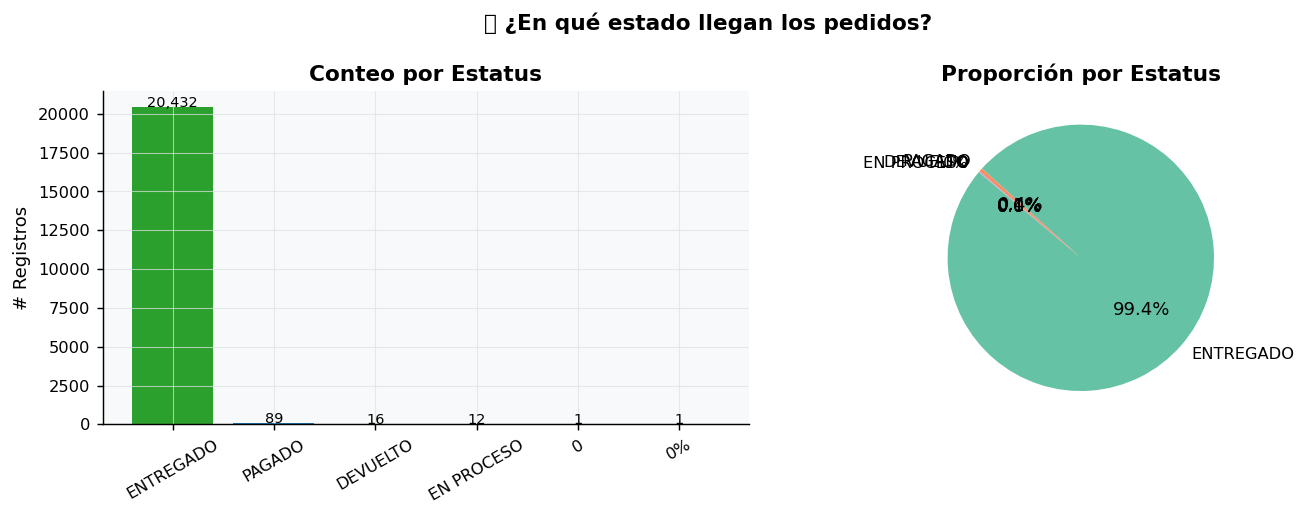


✅ Entregados: 99.4% del total


In [6]:
# ── CELDA 2: Distribución de Estatus de pedidos ─────────────────────────────
est = df["Estatus"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Barras
axes[0].bar(est.index, est.values,
            color=["#2ca02c" if e == "ENTREGADO" else "#d62728" if "CANCEL" in str(e)
                   else "#1f77b4" for e in est.index])
axes[0].set_title("Conteo por Estatus", fontweight="bold")
axes[0].set_ylabel("# Registros")
axes[0].tick_params(axis="x", rotation=30)
for i, v in enumerate(est.values):
    axes[0].text(i, v + 5, f"{v:,}", ha="center", fontsize=8)

# Pastel
axes[1].pie(est.values, labels=est.index, autopct="%1.1f%%",
            startangle=140, colors=plt.cm.Set2.colors)
axes[1].set_title("Proporción por Estatus", fontweight="bold")

plt.suptitle("📦 ¿En qué estado llegan los pedidos?", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("02_estatus.png")
plt.show()

pct_entregado = est.get("ENTREGADO", 0) / est.sum() * 100
print(f"\n✅ Entregados: {pct_entregado:.1f}% del total")

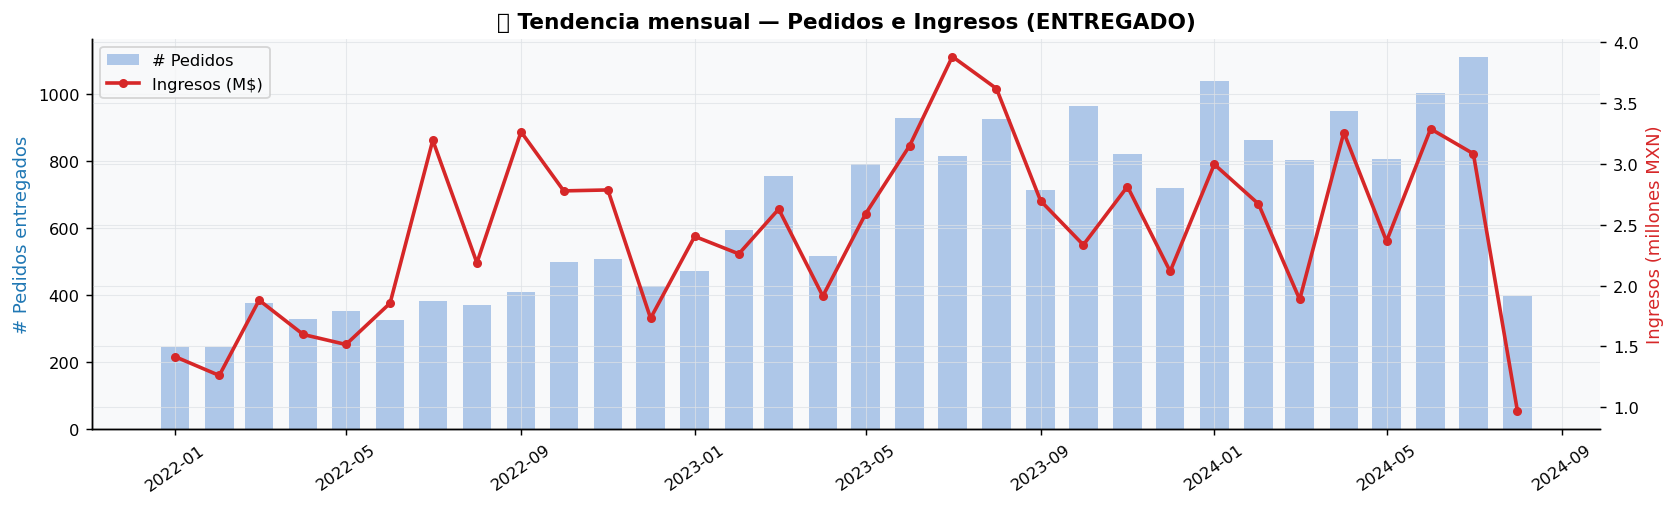

In [7]:
# ── CELDA 3: Tendencia mensual de ventas ─────────────────────────────────────
df_ent = df[df["Estatus"] == "ENTREGADO"].copy()
df_ent["Mes"] = df_ent["Fecha_Ini"].dt.to_period("M")

mensual = (df_ent.groupby("Mes")
                 .agg(Pedidos=("ID", "count"),
                      Ingresos=("Total", "sum"))
                 .reset_index())
mensual["Mes_dt"] = mensual["Mes"].dt.to_timestamp()

fig, ax1 = plt.subplots(figsize=(13, 4))
ax2 = ax1.twinx()

ax1.bar(mensual["Mes_dt"], mensual["Pedidos"],
        width=20, color="#aec7e8", label="# Pedidos")
ax2.plot(mensual["Mes_dt"], mensual["Ingresos"] / 1e6,
         color="#d62728", lw=2, marker="o", ms=4, label="Ingresos (M$)")

ax1.set_ylabel("# Pedidos entregados", color="#1f77b4")
ax2.set_ylabel("Ingresos (millones MXN)", color="#d62728")
ax1.set_title("📈 Tendencia mensual — Pedidos e Ingresos (ENTREGADO)", fontweight="bold")
ax1.tick_params(axis="x", rotation=35)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.savefig("03_ventas_mensuales.png")
plt.show()

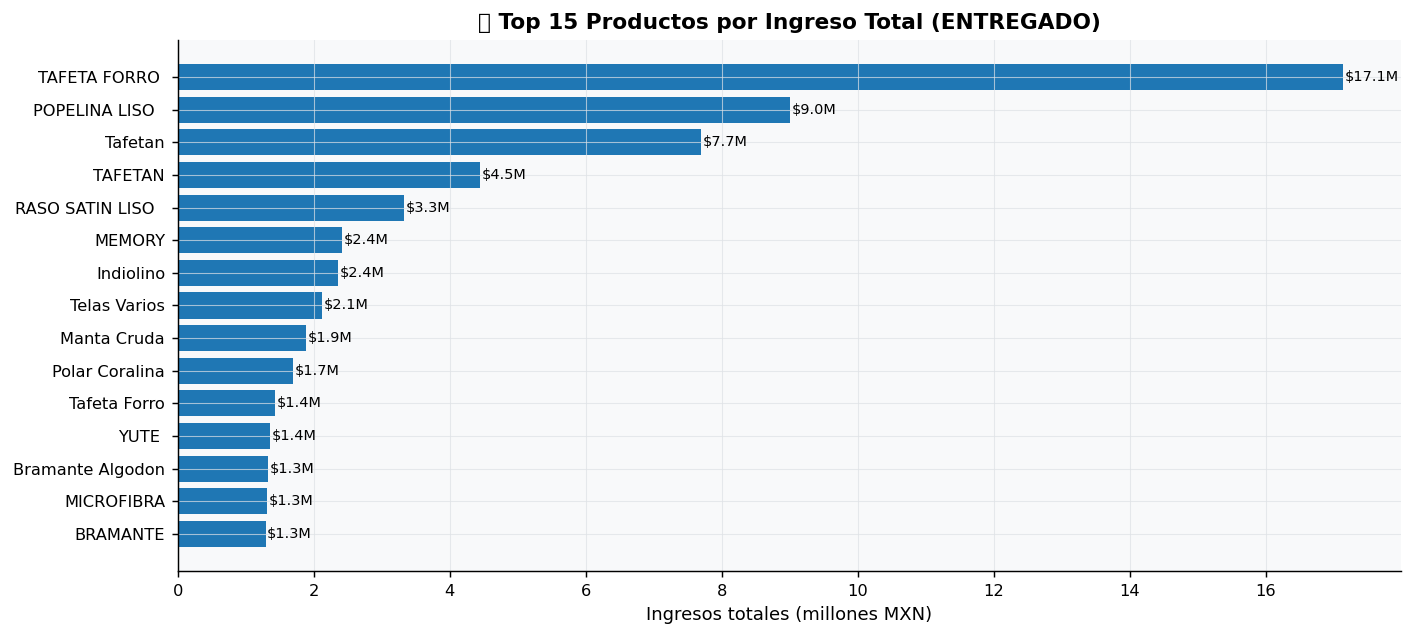


📊 Top 5 productos:
            Producto     Ingresos  Pedidos  Cant_total
0      TAFETA FORRO   17138665.06     4067  3090247.61
1    POPELINA LISO     9003537.17     2340   537233.13
2            Tafetan   7695880.11     1326   462588.25
3            TAFETAN   4452790.58     2249   331490.79
4  RASO SATIN LISO     3332748.82     1614   335080.49


In [8]:
# ── CELDA 4: Top 15 productos por ingreso total ──────────────────────────────
top = (df_ent.groupby("Producto")
             .agg(Ingresos=("Total", "sum"),
                  Pedidos=("ID", "count"),
                  Cant_total=("Cant", "sum"))
             .sort_values("Ingresos", ascending=False)
             .head(15)
             .reset_index())

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.barh(top["Producto"][::-1], top["Ingresos"][::-1] / 1e6,
               color="#1f77b4")
ax.set_xlabel("Ingresos totales (millones MXN)")
ax.set_title("🏆 Top 15 Productos por Ingreso Total (ENTREGADO)", fontweight="bold")
for bar, val in zip(bars, top["Ingresos"][::-1] / 1e6):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2,
            f"${val:.1f}M", va="center", fontsize=8)
plt.tight_layout()
plt.savefig("04_top_productos.png")
plt.show()

print("\n📊 Top 5 productos:")
print(top[["Producto","Ingresos","Pedidos","Cant_total"]].head())

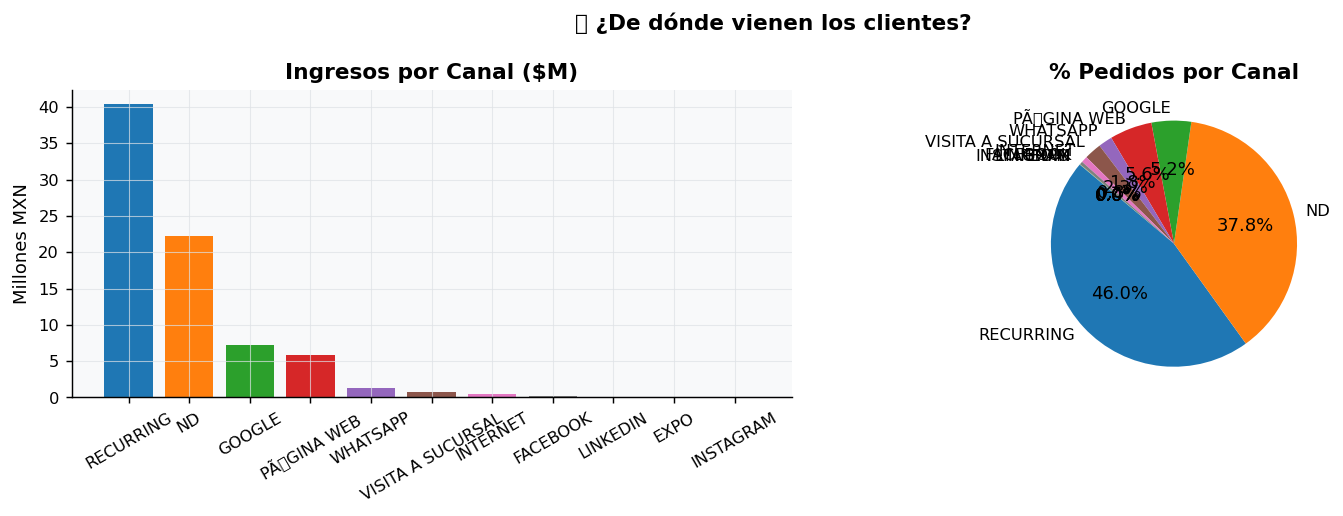

           Origen    Ingresos  Pedidos
        RECURRING 40331215.97     9406
               ND 22280588.69     7727
           GOOGLE  7243007.28     1064
      PÃGINA WEB  5831963.03     1138
         WHATSAPP  1344305.51      373
VISITA A SUCURSAL   773016.04      461
         INTERNET   416390.99      168
         FACEBOOK   152145.06       83
         LINKEDIN     9300.00        6
             EXPO     7110.00        4
        INSTAGRAM     1620.00        2


In [9]:
# ── CELDA 5: Mix por canal de Origen ─────────────────────────────────────────
canal = (df_ent.groupby("Origen")
               .agg(Ingresos=("Total","sum"),
                    Pedidos=("ID","count"))
               .sort_values("Ingresos", ascending=False)
               .reset_index())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = plt.cm.tab10.colors[:len(canal)]

# Por ingresos
axes[0].bar(canal["Origen"], canal["Ingresos"]/1e6, color=colors)
axes[0].set_title("Ingresos por Canal ($M)", fontweight="bold")
axes[0].set_ylabel("Millones MXN")
axes[0].tick_params(axis="x", rotation=30)

# Por pedidos
axes[1].pie(canal["Pedidos"], labels=canal["Origen"],
            autopct="%1.1f%%", colors=colors, startangle=140)
axes[1].set_title("% Pedidos por Canal", fontweight="bold")

plt.suptitle("📡 ¿De dónde vienen los clientes?", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("05_canal_origen.png")
plt.show()

print(canal.to_string(index=False))

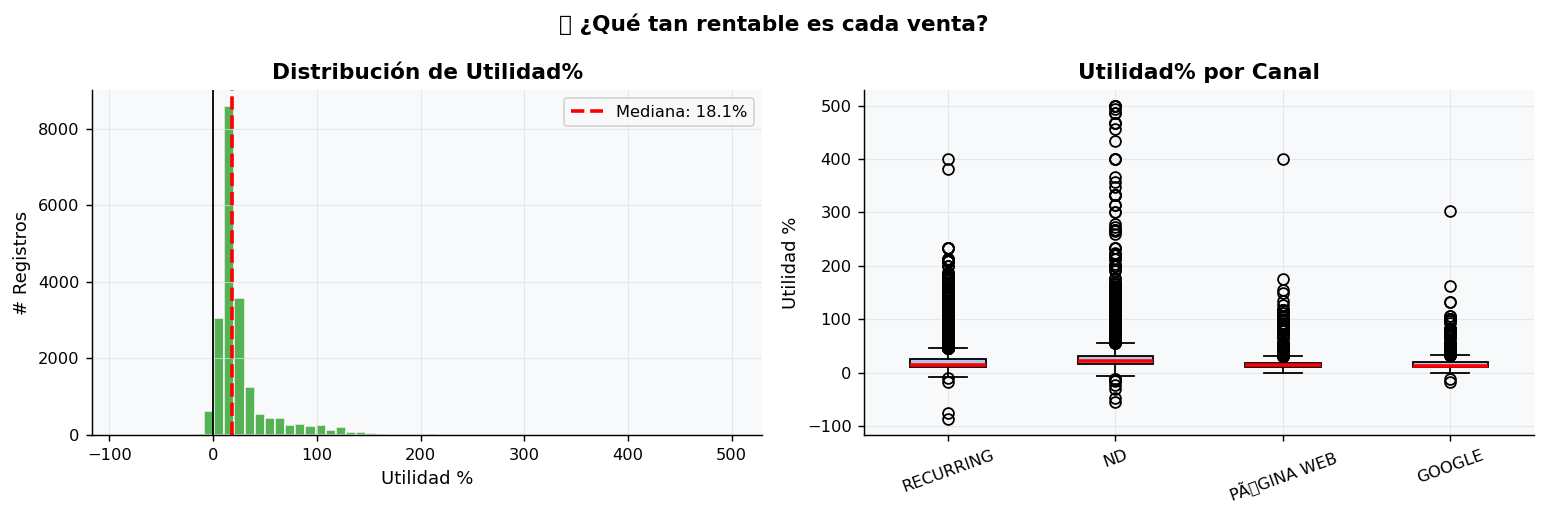

count    20219.00
mean        27.41
std         32.19
min        -87.10
25%         12.01
50%         18.15
75%         27.40
max        500.00
Name: Utilidad%, dtype: float64


In [10]:
# ── CELDA 6: Distribución de Utilidad% ──────────────────────────────────────
df_margen = df_ent[df_ent["Utilidad%"].between(-200, 500)].copy()  # filtro outliers extremos

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma
axes[0].hist(df_margen["Utilidad%"].dropna(), bins=60,
             color="#2ca02c", edgecolor="white", alpha=0.8)
axes[0].axvline(df_margen["Utilidad%"].median(), color="red",
                ls="--", lw=2, label=f"Mediana: {df_margen['Utilidad%'].median():.1f}%")
axes[0].axvline(0, color="black", ls="-", lw=1)
axes[0].set_xlabel("Utilidad %")
axes[0].set_ylabel("# Registros")
axes[0].set_title("Distribución de Utilidad%", fontweight="bold")
axes[0].legend()

# Boxplot por top canales
top_canales = df_ent["Origen"].value_counts().head(4).index
df_box = df_margen[df_margen["Origen"].isin(top_canales)]
groups = [df_box[df_box["Origen"]==c]["Utilidad%"].dropna() for c in top_canales]
axes[1].boxplot(groups, labels=top_canales, patch_artist=True,
                boxprops=dict(facecolor="#aec7e8"),
                medianprops=dict(color="red", lw=2))
axes[1].set_title("Utilidad% por Canal", fontweight="bold")
axes[1].set_ylabel("Utilidad %")
axes[1].tick_params(axis="x", rotation=20)

plt.suptitle("💰 ¿Qué tan rentable es cada venta?", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("06_margen.png")
plt.show()

print(df_margen["Utilidad%"].describe().round(2))


Cant — percentiles:
0.25        13.00
0.50       100.00
0.75       200.00
0.95     1,000.00
0.99     4,000.00
1.00    30,000.00

Total — percentiles:
0.25        450.00
0.50      1,053.50
0.75      2,800.00
0.95     13,500.00
0.99     52,412.39
1.00    710,500.00


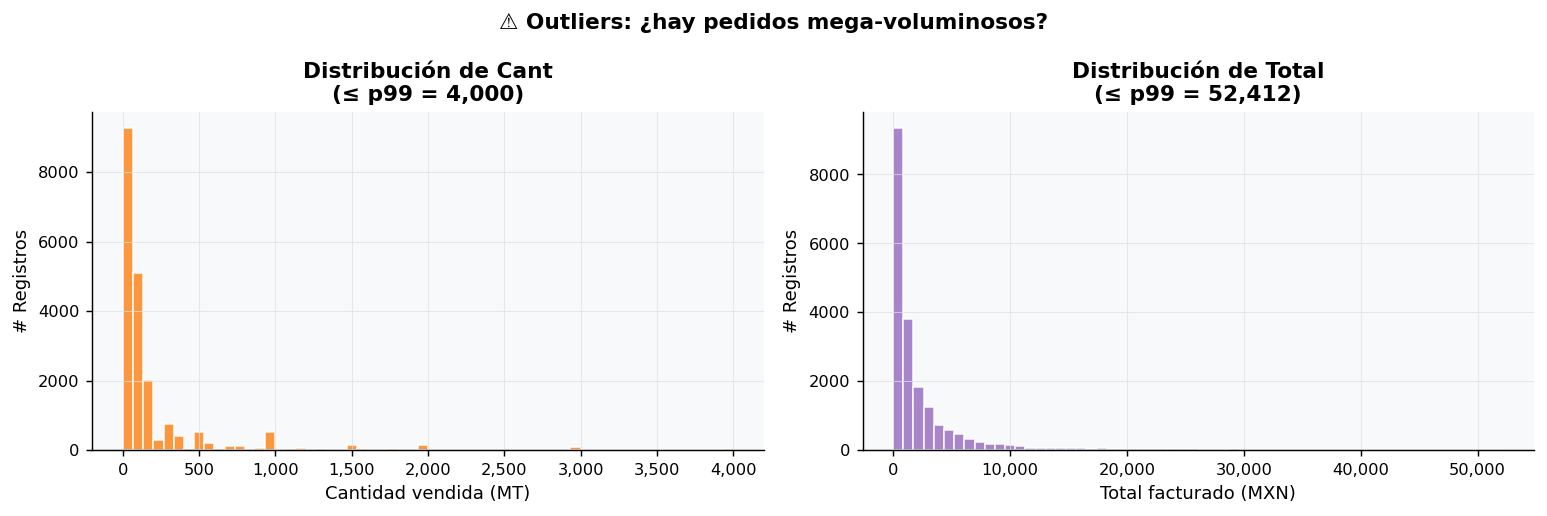

In [11]:
# ── CELDA 7: Outliers en Cant y Total ────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col, color, label in zip(
        axes,
        ["Cant", "Total"],
        ["#ff7f0e", "#9467bd"],
        ["Cantidad vendida (MT)", "Total facturado (MXN)"]):

    data = df_ent[col].dropna()
    q99  = data.quantile(0.99)

    ax.hist(data[data <= q99], bins=60, color=color,
            edgecolor="white", alpha=0.8)
    ax.set_title(f"Distribución de {col}\n(≤ p99 = {q99:,.0f})", fontweight="bold")
    ax.set_xlabel(label)
    ax.set_ylabel("# Registros")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(
        lambda x, _: f"{x:,.0f}"))

    # Tabla de percentiles
    pct = data.quantile([0.25,0.5,0.75,0.95,0.99,1.0])
    print(f"\n{col} — percentiles:")
    print(pct.apply(lambda v: f"{v:,.2f}").to_string())

plt.suptitle("⚠️ Outliers: ¿hay pedidos mega-voluminosos?", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("07_outliers.png")
plt.show()

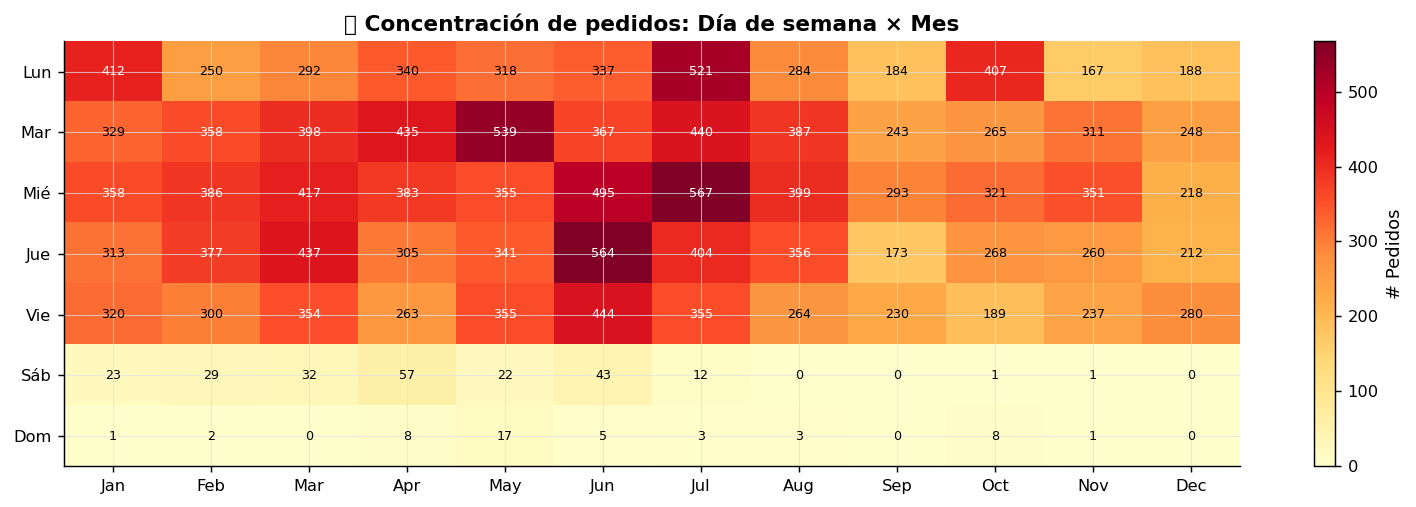

In [12]:
# ── CELDA 8: Heatmap de pedidos por día de semana × mes del año ──────────────
df_ent["DiaSemana"] = df_ent["Fecha_Ini"].dt.day_name()
df_ent["MesNum"]    = df_ent["Fecha_Ini"].dt.month
df_ent["MesNom"]    = df_ent["Fecha_Ini"].dt.strftime("%b")

dias_orden = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot = (df_ent.groupby(["DiaSemana","MesNum"])["ID"]
               .count()
               .unstack(fill_value=0)
               .reindex(dias_orden))
pivot.columns = pd.to_datetime(pivot.columns, format="%m").strftime("%b")

fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pivot.values, aspect="auto", cmap="YlOrRd")
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"])
plt.colorbar(im, ax=ax, label="# Pedidos")

for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        ax.text(j, i, str(pivot.values[i,j]),
                ha="center", va="center", fontsize=7,
                color="white" if pivot.values[i,j] > pivot.values.max()*0.6 else "black")

ax.set_title("📅 Concentración de pedidos: Día de semana × Mes", fontweight="bold")
plt.tight_layout()
plt.savefig("08_heatmap_tiempo.png")
plt.show()

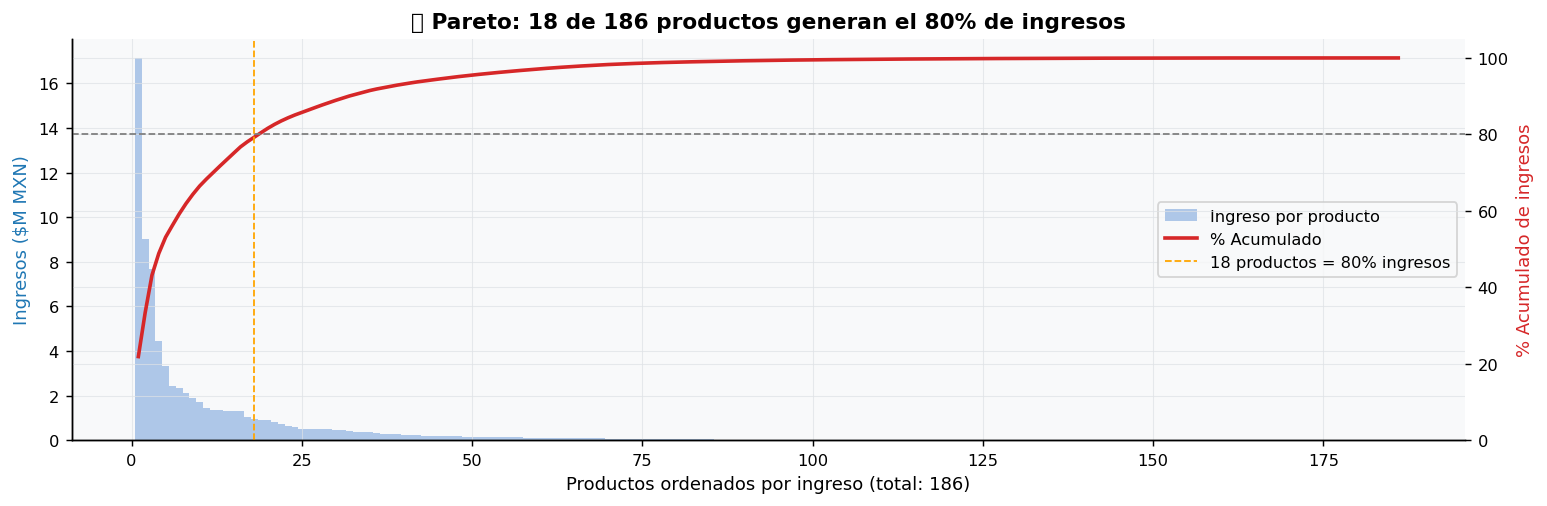


🎯 Pareto 80/20:
   18 productos (9.7%) generan el 80% del ingreso

Top 10 productos ($52.1M):
         Producto       Total
    TAFETA FORRO  17138665.06
  POPELINA LISO    9003537.17
          Tafetan  7695880.11
          TAFETAN  4452790.58
RASO SATIN LISO    3332748.82
           MEMORY  2420504.13
        Indiolino  2359334.38
     Telas Varios  2122499.67
      Manta Cruda  1893872.84
   Polar Coralina  1701030.39


In [13]:
# ── CELDA 9: Curva de Pareto — % acumulado de ingresos por producto ──────────
pareto = (df_ent.groupby("Producto")["Total"]
                .sum()
                .sort_values(ascending=False)
                .reset_index())
pareto["cum_pct"] = pareto["Total"].cumsum() / pareto["Total"].sum() * 100
pareto["rank"]    = range(1, len(pareto)+1)

p80 = pareto[pareto["cum_pct"] <= 80].shape[0]
total_prods = len(pareto)

fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

ax1.bar(pareto["rank"], pareto["Total"]/1e6,
        color="#aec7e8", width=1, label="Ingreso por producto")
ax2.plot(pareto["rank"], pareto["cum_pct"],
         color="#d62728", lw=2, label="% Acumulado")
ax2.axhline(80, color="gray", ls="--", lw=1)
ax2.axvline(p80, color="orange", ls="--", lw=1,
            label=f"{p80} productos = 80% ingresos")

ax1.set_xlabel(f"Productos ordenados por ingreso (total: {total_prods})")
ax1.set_ylabel("Ingresos ($M MXN)", color="#1f77b4")
ax2.set_ylabel("% Acumulado de ingresos", color="#d62728")
ax2.set_ylim(0,105)

lines  = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
ax1.legend(lines, labels, loc="center right")

ax1.set_title(f"📊 Pareto: {p80} de {total_prods} productos generan el 80% de ingresos",
              fontweight="bold")
plt.tight_layout()
plt.savefig("09_pareto.png")
plt.show()

print(f"\n🎯 Pareto 80/20:")
print(f"   {p80} productos ({p80/total_prods*100:.1f}%) generan el 80% del ingreso")
print(f"\nTop 10 productos (${pareto['Total'].head(10).sum()/1e6:.1f}M):")
print(pareto[["Producto","Total"]].head(10).to_string(index=False))

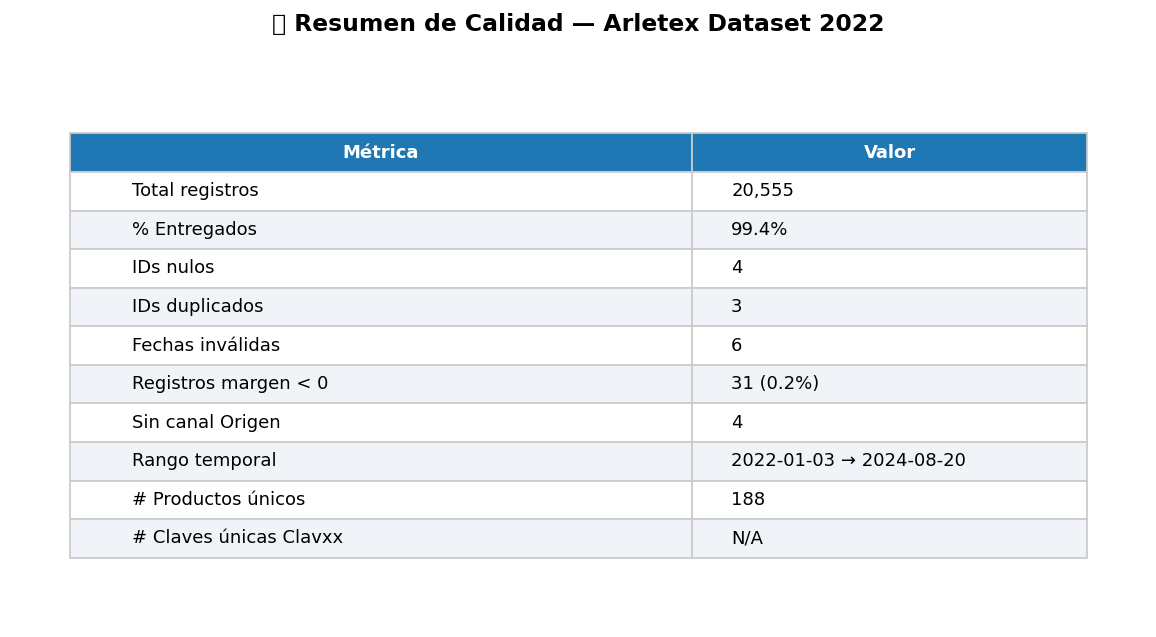


📌 Hallazgos clave para siguiente fase:
  ✅ Usar solo registros ENTREGADO para análisis de demanda
  ⚠️  Validar registros con Utilidad% negativa o > 300%
  ⚠️  Cant > 1,000 MT son pedidos b2b: tratar por separado
  ❌  No hay datos de cliente/comprador → no se puede hacer CLV todavía
  ❌  No hay stock/inventario → no se puede hacer fill-rate


In [14]:
# ── CELDA 10: Resumen ejecutivo de calidad de datos ──────────────────────────
total     = len(df)
entregado = (df["Estatus"]=="ENTREGADO").sum()
nulos_id  = df["ID"].isnull().sum()
dups      = df.duplicated(subset=["ID"]).sum()
sin_fecha = df["Fecha_Ini"].isnull().sum()
margen_neg = (df_ent["Utilidad"] < 0).sum()
sin_origen = df["Origen"].isnull().sum() + (df["Origen"].astype(str).str.strip()=="").sum()
rango_fechas = f"{df['Fecha_Ini'].min().date()} → {df['Fecha_Ini'].max().date()}"

metricas = {
    "Total registros":         f"{total:,}",
    "% Entregados":            f"{entregado/total*100:.1f}%",
    "IDs nulos":               f"{nulos_id}",
    "IDs duplicados":          f"{dups}",
    "Fechas inválidas":        f"{sin_fecha}",
    "Registros margen < 0":    f"{margen_neg:,} ({margen_neg/entregado*100:.1f}%)",
    "Sin canal Origen":        f"{sin_origen}",
    "Rango temporal":          rango_fechas,
    "# Productos únicos":      f"{df['Producto'].nunique()}",
    "# Claves únicas Clavxx":  f"{df.get('Clave_Producto', df.get('Clav', pd.Series())).nunique() if 'Clave_Producto' in df.columns or 'Clav' in df.columns else 'N/A'}",
}

fig, ax = plt.subplots(figsize=(9, 5))
ax.axis("off")
rows = [[k, v] for k, v in metricas.items()]
tabla = ax.table(cellText=rows,
                 colLabels=["Métrica", "Valor"],
                 cellLoc="left", loc="center",
                 colWidths=[0.55, 0.35])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.6)

for (r, c), cell in tabla.get_celld().items():
    if r == 0:
        cell.set_facecolor("#1f77b4")
        cell.set_text_props(color="white", fontweight="bold")
    elif r % 2 == 0:
        cell.set_facecolor("#f0f4f8")
    cell.set_edgecolor("#cccccc")

ax.set_title("🗂️ Resumen de Calidad — Arletex Dataset 2022",
             fontsize=13, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig("10_resumen_calidad.png", bbox_inches="tight")
plt.show()

print("\n📌 Hallazgos clave para siguiente fase:")
print("  ✅ Usar solo registros ENTREGADO para análisis de demanda")
print("  ⚠️  Validar registros con Utilidad% negativa o > 300%")
print("  ⚠️  Cant > 1,000 MT son pedidos b2b: tratar por separado")
print("  ❌  No hay datos de cliente/comprador → no se puede hacer CLV todavía")
print("  ❌  No hay stock/inventario → no se puede hacer fill-rate")